In [50]:
import matplotlib.pyplot as plt
import os, math
import pandas as pd
import xml.etree.ElementTree as et
import urllib.request
from datetime import *
from scipy import stats
import numpy as np

In [29]:
def parse_XML(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas DataFrame with the given columns. 
    The first element of df_cols is supposed to be the identifier variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content of each sub-element. 
    """
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        res.append(node.attrib.get(df_cols[0]))
        for el in df_cols[1:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df 


In [30]:
sDate = datetime.strptime("09/08/2020 13", "%m/%d/%Y %H")

In [31]:
xml_fmgf = "wfas_fmg.xml"
url = 'https://fam.nwcg.gov/wims/xsql/nfdrs.xsql?stn=&sig=bgbear&user=bgardunio&type=N&start=01-Jan-2020&end=31-Dec-2020&time=RS&fmodel=16Y'

urllib.request.urlretrieve(url, xml_fmgf)

('wfas_fmg.xml', <http.client.HTTPMessage at 0x28a10270e48>)

In [32]:
df = parse_XML(xml_fmgf, ["id","sta_id", "nfdr_dt", "nfdr_tm", "latitude","longitude","ec","bi","hu_hr","th_hr","ic","ten_hr"])

In [33]:
df

,id,sta_id,nfdr_dt,nfdr_tm,latitude,longitude,ec,bi,hu_hr,th_hr,ic,ten_hr
0,None,40916,12/31/2020,12,40.0019,-120.9150,13.3,0,17.73,17.87,0,20.34
1,None,41214,12/31/2020,12,39.7359,-121.4890,18.3,26.9,17.07,18.03,4.7,21.79
2,None,41304,12/31/2020,12,39.6361,-120.8640,21.8,0,14.21,14.98,0,18.22
3,None,40916,12/30/2020,12,40.0019,-120.9150,23.9,16.9,17.83,17.77,2.3,14.39
4,None,41214,12/30/2020,12,39.7359,-121.4890,23.8,21.7,17.09,18.05,11.2,11.81
...,...,...,...,...,...,...,...,...,...,...,...,...
1073,None,41214,01/02/2020,12,39.7359,-121.4890,19,24.3,16.24,19.75,12.1,17.38
1074,None,41304,01/02/2020,12,39.6361,-120.8640,0,0,24.84,24.99,0,25.71
1075,None,40916,01/01/2020,12,40.0019,-120.9150,18.4,14,16.56,18.94,1.6,16.25
1076,None,41214,01/01/2020,12,39.7359,-121.4890,18.1,17.4,16.05,20.18,4.7,15.19


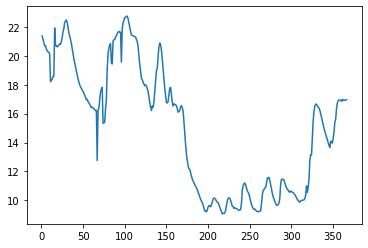

In [34]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.latitude = df.latitude.astype("float32")
df.longitude = df.longitude.astype("float32")
df.ten_hr = df.ten_hr.astype("float32")
df.hu_hr = df.hu_hr.astype("float32")
df.th_hr = df.th_hr.astype("float32")
df.ec = df.ec.astype("float32")
df.bi = df.bi.astype("float32")
df.ic = df.ic.astype("float32")
df['DateTime']=pd.to_datetime(df['nfdr_dt'].astype(str) + " " + df['nfdr_tm'].astype(str), format='%m/%d/%Y %H')
df['DateTime']=pd.to_datetime(df['nfdr_dt'].astype(str) + " 13" , format='%m/%d/%Y %H')
JDay = []
for index, row in df.iterrows():
    jday = int(row.DateTime.strftime(format="%j"))
    JDay.append(jday)



df['JDay'] = JDay
df = df.groupby(by="DateTime").mean()
df['DateTime'] = df.index
plt.plot(df.JDay,df.th_hr)

In [35]:
df.describe()

,latitude,longitude,ec,bi,hu_hr,th_hr,ic,ten_hr,JDay
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,39.794334,-121.095055,37.486206,26.022694,14.509324,15.043872,21.449041,14.776124,183.378082
std,0.015726,0.030480,22.731379,15.155736,4.738511,4.407269,17.285307,6.192591,105.918819
min,39.735901,-121.488998,1.666667,0.000000,7.630000,9.066667,0.000000,6.330000,1.000000
25%,39.791302,-121.089333,17.799999,12.700000,9.833333,10.480000,5.166667,9.370000,92.000000
50%,39.791302,-121.089333,30.866667,25.100000,14.764999,16.206667,15.933333,14.636667,183.000000
75%,39.791302,-121.089333,62.233334,40.400002,18.369999,18.410000,37.033333,19.313334,275.000000
max,39.868900,-121.089333,74.466667,75.600006,24.840000,22.736668,64.400002,33.310001,366.000000


In [9]:
Metbgbear = pd.read_csv(r'bgbear2.csv')
Metbgbear.rename(columns=lambda x: x.strip(), inplace=True)
Metbgbear=Metbgbear.drop(Metbgbear.columns[[3]],axis=1)
Metbgbear['DateTime']=pd.to_datetime(Metbgbear['DATE'].astype(str) + " 13", format='%m/%d/%Y %H')



JDay = []
for index, row in Metbgbear.iterrows():
    jday = int(row.DateTime.strftime(format="%j"))
    JDay.append(jday)
Metbgbear['JDay'] = JDay

In [10]:
Metbgbear.F1000.describe()

count    3650.000000
mean       16.611945
std         4.861564
min         8.000000
25%        12.000000
50%        17.500000
75%        21.000000
max        25.700000
Name: F1000, dtype: float64

In [11]:
Metbgbear.describe()

,ERC,BI,F1000,JDay
count,3650.000000,3650.000000,3650.000000,3650.000000
mean,30.338000,20.752548,16.611945,183.167671
std,24.096486,16.012352,4.861564,105.428067
min,0.300000,0.000000,8.000000,1.000000
25%,8.500000,6.325000,12.000000,92.000000
50%,23.300000,17.500000,17.500000,183.000000
75%,53.000000,36.000000,21.000000,274.000000
max,79.400000,56.800000,25.700000,366.000000


In [12]:
Metbgbear['DateTime'].describe()
Metbgbear['ERCPerc']=Metbgbear.ERC.rank(pct=True)
Metbgbear['BIPerc'] = Metbgbear.BI.rank(pct=True)
Metbgbear['F1000Perc']=Metbgbear.F1000.rank(pct=True)
Metbgbear['SFDIcont'] = Metbgbear['ERCPerc']* Metbgbear['BIPerc']
Metbgbear['SFDI']=Metbgbear.SFDIcont.rank(pct=True) * 100

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


In [13]:
Metbgbear.F1000.describe()

count    3650.000000
mean       16.611945
std         4.861564
min         8.000000
25%        12.000000
50%        17.500000
75%        21.000000
max        25.700000
Name: F1000, dtype: float64

In [14]:
Metbgbear.describe()

,ERC,BI,F1000,JDay,ERCPerc,BIPerc,F1000Perc,SFDIcont,SFDI
count,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000
mean,30.338000,20.752548,16.611945,183.167671,0.500137,0.500137,0.500137,0.330523,50.013699
std,24.096486,16.012352,4.861564,105.428067,0.288712,0.288019,0.288702,0.297310,28.871209
min,0.300000,0.000000,8.000000,1.000000,0.000959,0.084521,0.001096,0.000081,0.095890
25%,8.500000,6.325000,12.000000,92.000000,0.249589,0.249589,0.253014,0.060560,25.020548
50%,23.300000,17.500000,17.500000,183.000000,0.500000,0.500411,0.500274,0.242797,50.013699
75%,53.000000,36.000000,21.000000,274.000000,0.750000,0.749589,0.748767,0.567142,75.006849
max,79.400000,56.800000,25.700000,366.000000,0.999863,1.000000,0.999863,0.996715,100.000000


In [15]:
Temp2 = Metbgbear
Temp = Metbgbear
Temp2 = Temp2[(Temp2['DateTime'] > '1900-01-01') & (Temp2['DateTime'] <= '2019-12-31')]
g = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['F1000'].mean().reset_index()
gmx = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['F1000'].max().reset_index()
gmn = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['F1000'].min().reset_index()

<AxesSubplot:>

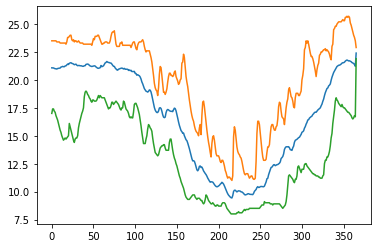

In [16]:
g.F1000.plot()
gmx.F1000.plot()
gmn.F1000.plot()

<AxesSubplot:xlabel='DateTime'>

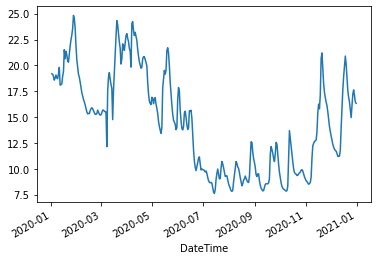

In [17]:
df.hu_hr.plot()

In [18]:
p=Temp['ERC'].quantile([0.6,0.9,0.97])
pBI=Temp['BI'].quantile([0.6,0.9,0.97])
pF1000=Temp['F1000'].quantile([.10,.03])
p
pF1000

0.10    9.7
0.03    8.8
Name: F1000, dtype: float64

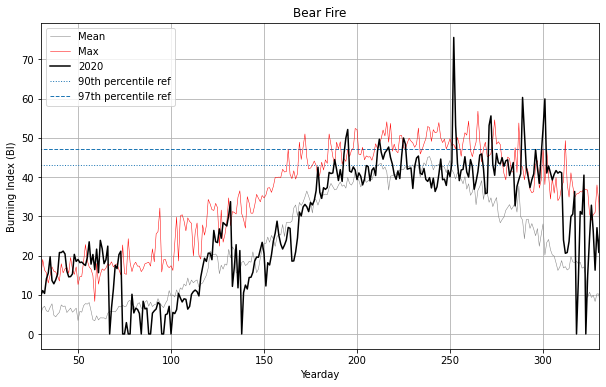

In [19]:
Temp2 = Metbgbear
Temp2 = Temp2[(Temp2['DateTime'] > '1900-01-01') & (Temp2['DateTime'] <= '2019-12-31')]
g = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['BI'].mean().reset_index()
gmx = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['BI'].max().reset_index()
gmn = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['BI'].min().reset_index()
f, ax = plt.subplots(figsize=(10,6))
plt.plot(g['DateTime'].astype(int),g['BI'],color='grey',label="Mean",linewidth=0.5)
plt.plot(gmx['DateTime'].astype(int),gmx['BI'],color='red',label="Max",linewidth=0.5)
plt.plot(df.JDay,df.bi,label="2020",color='black')
plt.grid()
plt.title("Bear Fire")
plt.gca().set_xlabel("Yearday")
plt.gca().set_ylabel("Burning Index (BI)")
plt.hlines(pBI[0.90],0,365,label="90th percentile ref",linestyle=":",linewidth=1)
plt.hlines(pBI[0.97],0,365,label="97th percentile ref",linestyle="--",linewidth=1)
plt.xlim(30,330)
plt.legend()


95.23287671232876
0.60    35.10
0.80    57.50
0.90    66.41
0.97    73.50
Name: ERC, dtype: float64


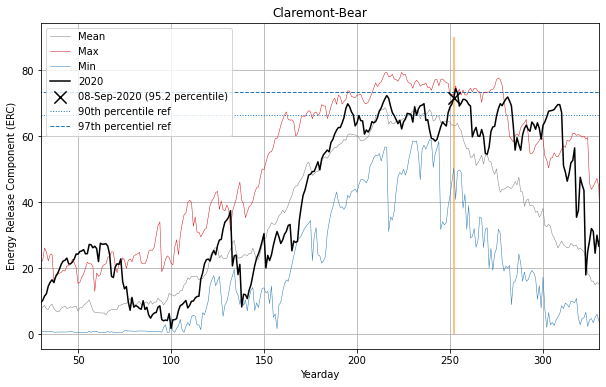

In [20]:
# Resample to daily precip sum and save as new dataframe
Temp=Metbgbear
Temp2 = Temp
g = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['ERC'].mean().reset_index()
gmx = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['ERC'].max().reset_index()
gmn = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['ERC'].min().reset_index()

f, ax = plt.subplots(figsize=(10,6))
plt.plot(g['DateTime'].astype(int),g['ERC'],color='grey',label="Mean",linewidth=0.5)
plt.plot(gmx['DateTime'].astype(int),gmx['ERC'],color='#d7191c',label="Max",linewidth=0.5)
plt.plot(gmn['DateTime'].astype(int),gmn['ERC'],color='#2c7bb6',label="Min",linewidth=0.5)

plt.plot(df.JDay,df.ec,label="2020",color='black')
plt.grid()
plt.title("Claremont-Bear")
plt.gca().set_xlabel("Yearday")
plt.gca().set_ylabel("Energy Release Component (ERC)")
#sDate = datetime.strptime("09/09/2020 13", "%m/%d/%Y %H")
erc_day = df[df['DateTime'] == sDate]

percentile = stats.percentileofscore(Metbgbear.ERC.values, erc_day.ec.values)
print(percentile)
p=Temp['ERC'].quantile([0.6,0.8,0.9,0.97])
print(p)
sDateTxt=sDate.strftime('%j')
#print(sDateTxt)
sDateTxt=sDate.strftime('%d-%b-%Y')
#print(sDateTxt)
#print(erc_day)
lab = "%s (%s percentile)" % (sDateTxt,round(percentile,1))
plt.scatter(erc_day.JDay,erc_day.ec,marker='x',c='black', s=150,zorder=3,label=lab)
plt.vlines(erc_day.JDay,0,90,color='#fdae61')
#plt.hlines(p[0.6],0,365,label="60th percentile ref",linestyle=(0, (3,1,1,1)),linewidth=1)
plt.hlines(p[0.9],0,365,label="90th percentile ref",linestyle=":",linewidth=1)
plt.hlines(p[0.97],0,365,label="97th percentiel ref",linestyle="--",linewidth=1)
plt.xlim(30,330)
plt.legend()
plt.savefig('bearfireERC2020.png')

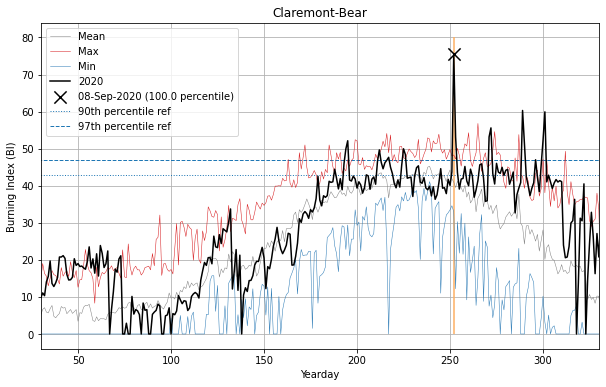

In [21]:
# Resample to daily prbiip sum and save as new dataframe
Temp=Metbgbear
Temp2 = Temp
g = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['BI'].mean().reset_index()
gmx = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['BI'].max().reset_index()
gmn = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['BI'].min().reset_index()

f, ax = plt.subplots(figsize=(10,6))
plt.plot(g['DateTime'].astype(int),g['BI'],color='grey',label="Mean",linewidth=0.5)
plt.plot(gmx['DateTime'].astype(int),gmx['BI'],color='#d7191c',label="Max",linewidth=0.5)
plt.plot(gmn['DateTime'].astype(int),gmn['BI'],color='#2c7bb6',label="Min",linewidth=0.5)

plt.plot(df.JDay,df.bi,label="2020",color='black')
plt.grid()
plt.title("Claremont-Bear")
plt.gca().set_xlabel("Yearday")
plt.gca().set_ylabel("Burning Index (BI)")

BI_day = df[df['DateTime'] == sDate]

percentile = stats.percentileofscore(Metbgbear.BI.values, BI_day.bi.values)

p=Temp['BI'].quantile([0.6,0.8,0.9,0.97])
#print(p)
sDateTxt=sDate.strftime('%j')
#print(sDateTxt)
sDateTxt=sDate.strftime('%d-%b-%Y')
#print(sDateTxt)
#print(BI_day)
lab = "%s (%s percentile)" % (sDateTxt,round(percentile,1))
plt.scatter(BI_day.JDay,BI_day.bi,marker='x',c='black', s=150,zorder=3,label=lab)
plt.vlines(BI_day.JDay,0,80,color='#fdae61')
#plt.hlines(p[0.6],0,365,label="60th percentile ref",linestyle=(0, (3,1,1,1)),linewidth=1)
plt.hlines(p[0.9],0,365,label="90th percentile ref",linestyle=":",linewidth=1)
plt.hlines(p[0.97],0,365,label="97th percentile ref",linestyle="--",linewidth=1)
plt.xlim(30,330)
plt.legend()
plt.savefig('bearfireBI2020.png')

This is awesome

0.10    9.7
0.03    8.8
Name: F1000, dtype: float64


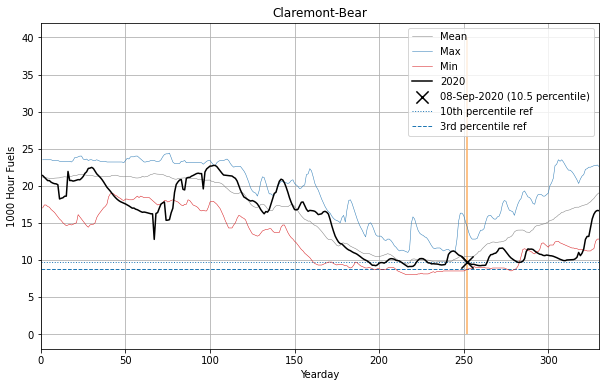

In [22]:
# Resample to daily prbiip sum and save as new dataframe
Temp=Metbgbear
Temp2 = Temp
g = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['F1000'].mean().reset_index()
gmx = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['F1000'].max().reset_index()
gmn = Temp2.groupby(Temp2['DateTime'].dt.dayofyear)['F1000'].min().reset_index()

f, ax = plt.subplots(figsize=(10,6))
plt.plot(g['DateTime'].astype(int),g['F1000'],color='grey',label="Mean",linewidth=0.5)
plt.plot(gmx['DateTime'].astype(int),gmx['F1000'],color='#2c7bb6',label="Max",linewidth=0.5)
plt.plot(gmn['DateTime'].astype(int),gmn['F1000'],color='#d7191c',label="Min",linewidth=0.5)

plt.plot(df.JDay,df.th_hr,label="2020",color='black')
plt.grid()
plt.title("Claremont-Bear")
plt.gca().set_xlabel("Yearday")
plt.gca().set_ylabel("1000 Hour Fuels")

F1000_day = df[df['DateTime'] == sDate]

percentile = stats.percentileofscore(Metbgbear.F1000.values, F1000_day.th_hr.values)

p=Temp['F1000'].quantile([0.10,0.03])
print(p)
sDateTxt=sDate.strftime('%j')
#print(sDateTxt)
sDateTxt=sDate.strftime('%d-%b-%Y')
#print(sDateTxt)
#print(BI_day)
lab = "%s (%s percentile)" % (sDateTxt,round(percentile,1))
plt.scatter(F1000_day.JDay,F1000_day.th_hr,marker='x',c='black', s=150,zorder=3,label=lab)
plt.vlines(F1000_day.JDay,0,40,color='#fdae61')
#plt.hlines(p[0.6],0,365,label="60th percentile ref",linestyle=(0, (3,1,1,1)),linewidth=1)
plt.hlines(p[0.10],0,365,label="10th percentile ref",linestyle=":",linewidth=1)
plt.hlines(p[0.03],0,365,label="3rd percentile ref",linestyle="--",linewidth=1)
plt.xlim(0,330)
plt.legend()
plt.savefig('bearfireF100020202.png')

In [23]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(df['DateTime'],df['JDay'],ecperc,biperc,sfdi)),
columns =['DateTime','JDay','ERCPerc','BIPerc','SFDI'])



df.SFDI.describe()
bins = [0, 60,80,90,97,110]
group_names = [1,2,3,4,5]
df['SFDIclass'] = pd.cut(df['SFDI'],bins,labels=group_names)

In [24]:
rng = pd.date_range(pd.Timestamp("2018-03-10 09:00"), periods=3, freq='s')
rng
#rng.strftime('%B %d, %Y, %r')

DatetimeIndex(['2018-03-10 09:00:00', '2018-03-10 09:00:01',
               '2018-03-10 09:00:02'],
              dtype='datetime64[ns]', freq='S')

In [36]:
from scipy import stats

ecperc = []
biperc = []
sfdi = []
for index, row in df.iterrows():
    ep = stats.percentileofscore(Metbgbear.ERC,row.ec)
    bip = stats.percentileofscore(Metbgbear.BI,row.bi)
    sfdicont = ep/100 * bip/100
    sfdip = stats.percentileofscore(Metbgbear.SFDIcont,sfdicont)
    #print(ep)
    ecperc.append(ep)
    biperc.append(bip)
    sfdi.append(sfdip)
#plt.plot(sfdi)
print(len(ecperc),len(biperc),len(df.ec.to_numpy()))

365 365 365


In [45]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df2 = pd.DataFrame(list(zip(df['DateTime'],df['JDay'],ecperc,biperc,sfdi)),
columns =['DateTime','JDay','ERCPerc','BIPerc','SFDI'])
#df2.SFDI.plot()
#df2.SFDI.describe()
bins = [0, 60,80,90,97,110]
group_names = [1,2,3,4,5]
df2['SFDIclass'] = pd.cut(df2['SFDI'],bins,labels=group_names)

In [46]:
df2

,DateTime,JDay,ERCPerc,BIPerc,SFDI,SFDIclass
0,2020-01-01 13:00:00,1,32.931507,34.904110,35.095890,1
1,2020-01-02 13:00:00,2,32.931507,37.835616,35.917808,1
2,2020-01-03 13:00:00,3,35.753425,38.958904,37.643836,1
3,2020-01-04 13:00:00,4,30.246575,28.465753,30.301370,1
4,2020-01-05 13:00:00,5,32.767123,36.794521,35.561644,1
...,...,...,...,...,...,...
360,2020-12-27 13:00:00,362,45.698630,37.205479,41.698630,1
361,2020-12-28 13:00:00,363,48.136986,38.958904,43.780822,1
362,2020-12-29 13:00:00,364,54.712329,61.397260,57.972603,1
363,2020-12-30 13:00:00,365,55.671233,58.712329,57.315068,1


In [47]:
bins = [0, 60,80,90,97,110]
group_names = [1,2,3,4,5]
df2['ERCclass'] = pd.cut(df2['ERCPerc'],bins,labels=group_names)
df2['ERCclass'].plot()

TypeError: no numeric data to plot

<AxesSubplot:>

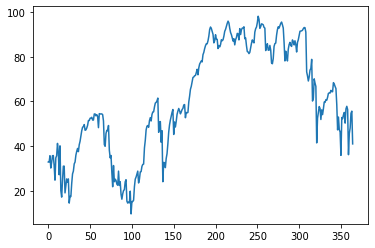

In [42]:
df2['ERCPerc'].plot()

In [43]:
df2['ERCclass']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
360    NaN
361    NaN
362    NaN
363    NaN
364    NaN
Name: ERCclass, Length: 365, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [44]:
df2['SFDIclass']


0      1
1      1
2      1
3      1
4      1
      ..
360    1
361    1
362    1
363    1
364    1
Name: SFDIclass, Length: 365, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

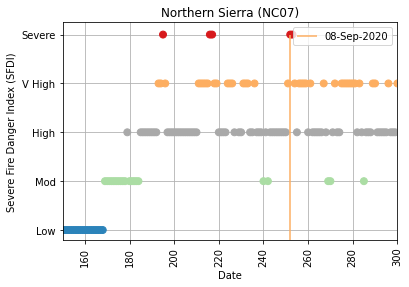

In [59]:
#plt.yticks(np.arange(0.5, 5.5, 1))
cols = ['#2b83ba','#abdda4','#a9a9a9','#fdae61','#d7191c']
cs = [cols[index-1] for index in df2['SFDIclass'] ]
plt.yticks(np.arange(6),['','Low','Mod','High','V High','Severe'])
plt.xticks(rotation=90)
#plt.plot(Temp2['DateTime'],Temp2['SFDIclass'],c='black')
plt.scatter(df2['JDay'],df2['SFDIclass'],s=48,c=cs ,zorder=2)
#plt.plot(Temp2['DateTime'],Temp2['SFDIclass'],linewidth = 0.5)
lab = "17 Sept 2020"
#plt.scatter(sDate,5,marker='x',c='black', s=150,zorder=3,label=lab)

plt.gca().set_xlabel("Date")
plt.gca().set_ylabel("Severe Fire Danger Index (SFDI)")
plt.grid(zorder=4)

plt.title("Claremont-Bear")

F1000_day = df[df['DateTime'] == sDate]

sDateTxt=sDate.strftime('%j')

sDateTxt=sDate.strftime('%d-%b-%Y')

lab = "%s (%s percentile)" % (sDateTxt,round(percentile,1))

plt.vlines(F1000_day.JDay,0,5,color='#fdae61',label=sDateTxt)
plt.ylim(bottom=0.8)
plt.xlim(150,300)
plt.legend()